In [1]:
# This notebook implements a simple autoencoder with only one hidden layer
# for the encoder and one other hidden layer for the decoder. The number of
# dimensions in the code layer is 32 and the loss function is binary crossentropy.

# The AE is trained and evaluated on the MNIST data set (28x28 pixel
# grayscale images flattened).

# For curiosity a set of other images are fed into the AE to see how it deals
# with images that are not similar to the train data.

In [2]:
import collections
import datetime
import json
import math
import random
import time

import cv2
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pylab
import scipy
import seaborn as sns
import skimage
import sklearn
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

fsize=(20.0, 15.0)
linewidth = 1.0
dotsize = 15

Using TensorFlow backend.


### Build the autoencoder

In [3]:
encoding_dim = 32

input_img = keras.layers.Input(shape=(784,))
encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = keras.models.Model(input_img, decoded)

In [4]:
encoder = keras.models.Model(input_img, encoded)

In [5]:
encoded_input = keras.layers.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.models.Model(encoded_input, decoder_layer(encoded_input))

In [6]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Prepare the data

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


### Training

In [9]:
n_epochs = 100

hist = autoencoder.fit(
            x_train,
            x_train,
            epochs=n_epochs,
            callbacks=[keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.005,
                            patience=10,
                            verbose=0,
                            mode='min')],
            batch_size=256,
            shuffle=True,
            validation_data=(x_test, x_test),
            verbose=0)

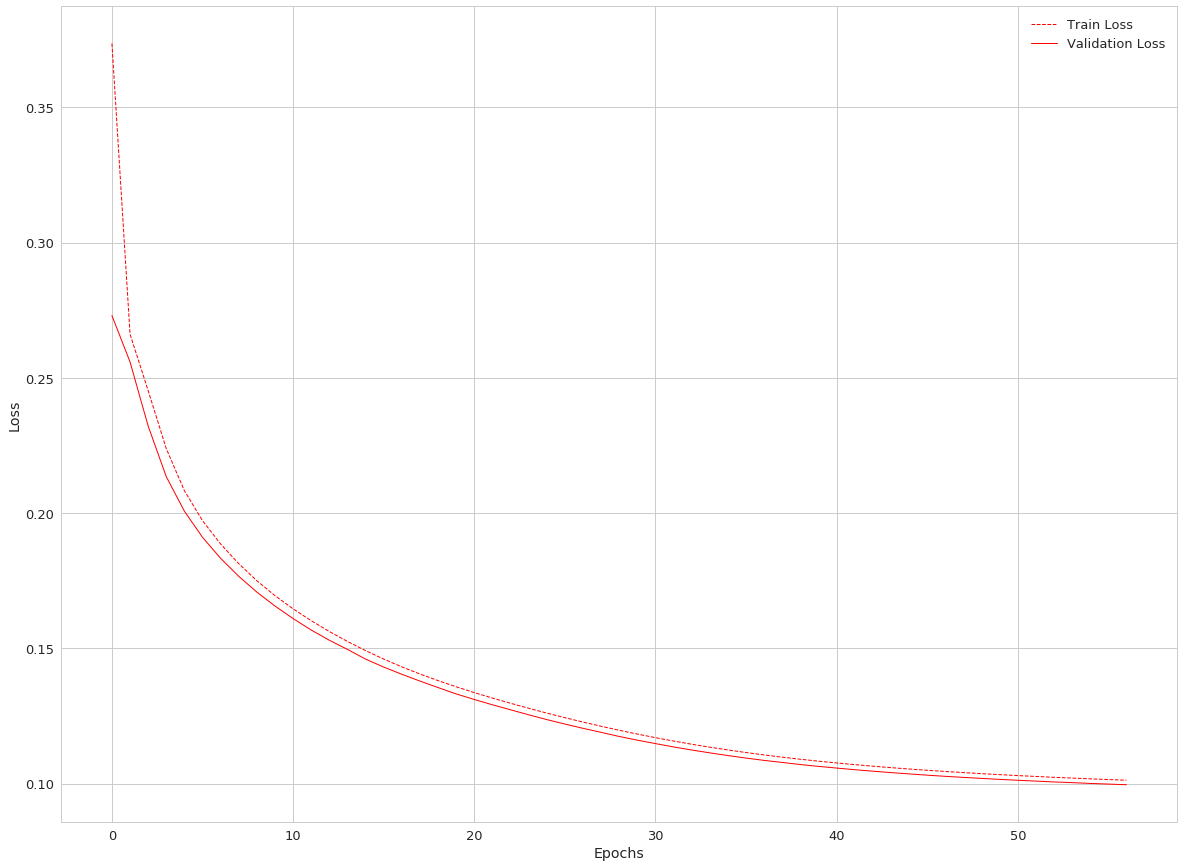

In [10]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

n_eps = range(len(loss))

_ = plt.figure(figsize=fsize)

_ = plt.plot(n_eps, loss, 'r--', label='Train Loss', linewidth=linewidth)
_ = plt.plot(n_eps, val_loss, 'r-', label='Validation Loss', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss')

_ = plt.legend()

### Visualize the results

In [11]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

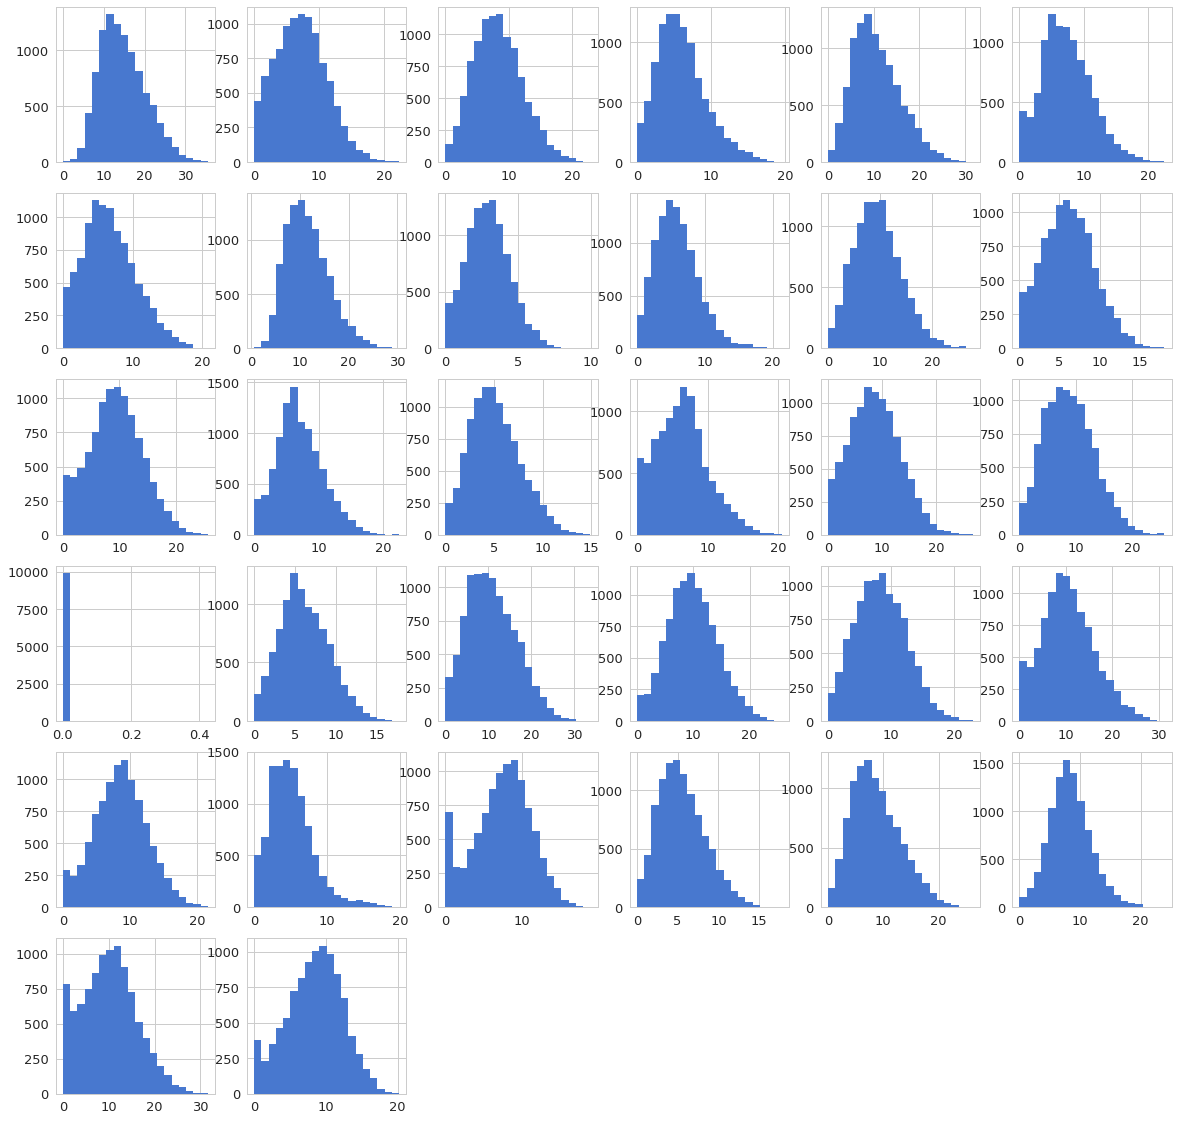

In [12]:
_ = plt.figure(figsize=(20, 20))

for i in range(32):
    ax = plt.subplot(6, 6, i + 1)
    plt.hist(encoded_imgs[:, i], bins=20)

In [13]:
def display_results(input_imgs, output_imgs, n_results, offset):
    _ = plt.figure(figsize=(20, int(40./n_results)))
    for i in range(n_results):
        ax = plt.subplot(2, n_results, i + 1)
        plt.imshow(input_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n_results, i + 1 + n_results)
        plt.imshow(output_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

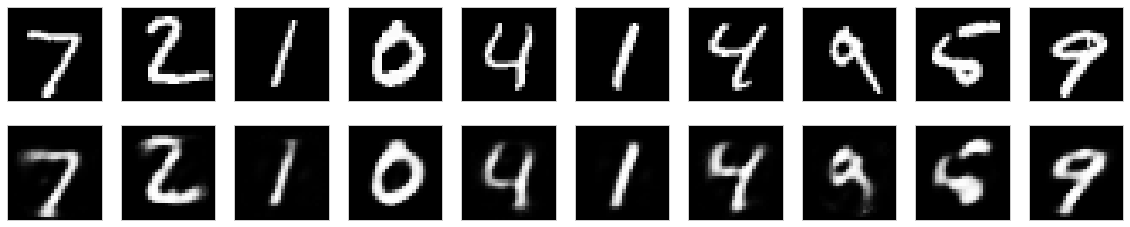

In [14]:
display_results(x_test, decoded_imgs, 10, 0)

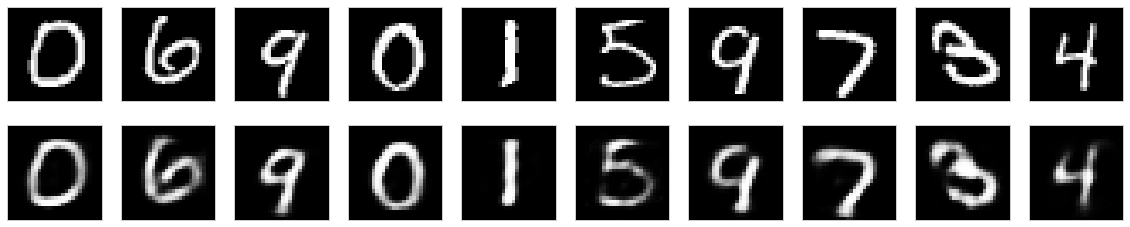

In [15]:
display_results(x_test, decoded_imgs, 10, 10)

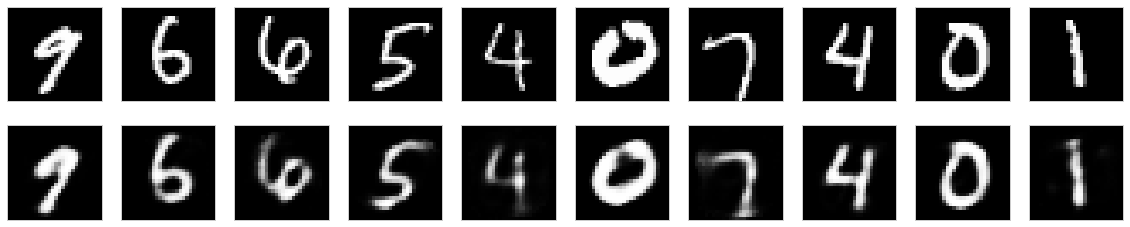

In [16]:
display_results(x_test, decoded_imgs, 10, 20)

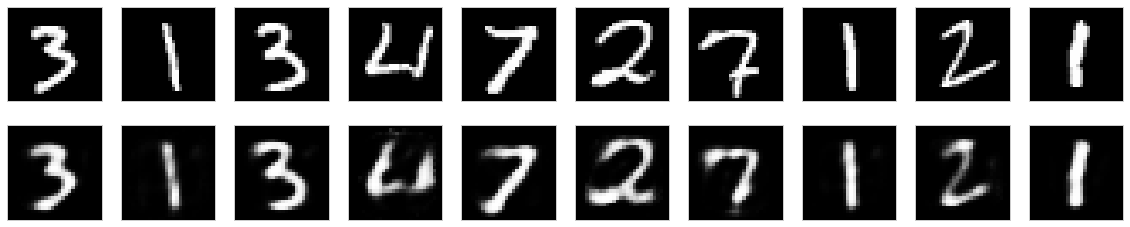

In [17]:
display_results(x_test, decoded_imgs, 10, 30)

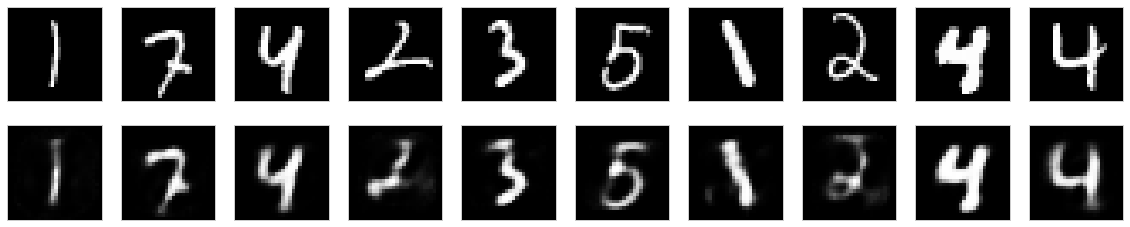

In [18]:
display_results(x_test, decoded_imgs, 10, 40)

### Let's see how it does on different types of images

In [19]:
novel_imgs = np.array([(cv2.imread('../data/ae_0{}.png'.format(i))[:,:,0]).reshape(784)/255. for i in range(10)])
encoded_novel_imgs = encoder.predict(novel_imgs)
decoded_novel_imgs = decoder.predict(encoded_novel_imgs)

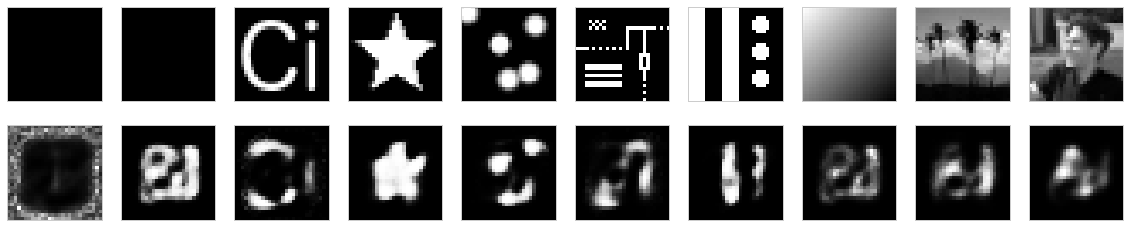

In [20]:
display_results(novel_imgs, decoded_novel_imgs, 10, 0)